In [1]:
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage

%matplotlib inline
from keras import layers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D,Add
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.models import Model
from keras.preprocessing import image
from keras.initializers import glorot_uniform
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input

Using TensorFlow backend.


ModuleNotFoundError: No module named 'tensorflow.contrib'

In [2]:
df= pd.read_csv('Train.csv')
train_y=df['label'].values.T
train_x=df.iloc[:,1:].values.astype('float32')
train_x=train_x.reshape(-1,28,28,1)
train_x.shape

(42000, 28, 28, 1)

In [3]:
temp_y=np.zeros((42000,10))
for i in range(42000):
    temp_y[i,train_y[i]]=1
train_y=temp_y.astype('int32')
train_x=train_x/255
train_y

array([[0, 1, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1]])

(42000, 10)


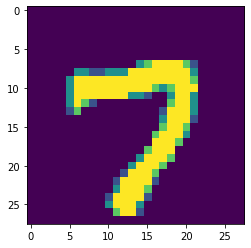

In [4]:
print(train_y.shape)
plt.imshow(train_x[41997,:,:,0])

In [61]:
def convolutional_block(X, f, filters, stage, block, s = 2):
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    # First component of main path 
    X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a',padding = 'same', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    

    # Second component of main path (≈3 lines)
    X = Conv2D(F2, (f, f), strides = (1,1), name = conv_name_base + '2b',padding = 'same', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(F3, (1, 1), strides = (1,1), name = conv_name_base + '2c',padding = 'valid', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    ##### SHORTCUT PATH #### (≈2 lines)
    X_shortcut = Conv2D(F3, (1, 1), strides = (s,s), name = conv_name_base + '1',padding = 'valid', kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X,X_shortcut])
    X = Activation('relu')(X)
    
    
    return X

In [62]:
def identity_block(X, f, filters, stage, block):
   
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    
    # Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    X = Add()([X,X_shortcut])
    X = Activation('relu')(X)
    
    
    return X

In [71]:
def ResNet50(input_shape = (28, 28, 1), classes = 10):
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    
    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], stage = 2, block='a', s = 1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')


    # AVGPOOL 
    X = AveragePooling2D(pool_size=(2, 2))(X)
    

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

In [5]:
def DigitModel(input_shape = (28, 28, 1), classes = 10):
    
    X_input = Input(input_shape)
    
    X = Conv2D(filters = 32, kernel_size = (3, 3), strides = (1,1), padding = 'same', name = 'conv1', activation = 'relu', kernel_initializer = glorot_uniform(seed=0))(X_input)
    #X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = MaxPooling2D(pool_size=(2, 2), strides = (2,2))(X)
    
    X = Conv2D(filters = 64, kernel_size = (5, 5), strides = (1,1), padding = 'same', name = 'conv2', activation = 'relu', kernel_initializer = glorot_uniform(seed=0))(X)
    #X = BatchNormalization(axis = 3, name = 'bn_conv2')(X)
    X = AveragePooling2D(pool_size=(2, 2), strides = (2,2))(X)
    
    X = Flatten()(X)
    X = Dropout(0.5,input_shape = (None,3136))(X)
    X = Dense(128, name = 'fc1', kernel_initializer = glorot_uniform(seed=0))(X)
    #X = Dense(84, activation = 'relu', name = 'fc2', kernel_initializer = glorot_uniform(seed=0))(X)
    X = Dropout(0.5,input_shape = (None, 128))(X)
    X = Dense(classes, activation = 'softmax', name = 'fc2', kernel_initializer = glorot_uniform(seed=0))(X)
    
     # Create model
    model = Model(inputs = X_input, outputs = X, name='LeNet5')

    return model

In [6]:
model = DigitModel(input_shape = (28, 28, 1), classes = 10)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(train_x, train_y, epochs = 100, batch_size = 420)

Epoch 1/100
 5040/42000 [==>...........................] - ETA: 27s - loss: 1.6901 - accuracy: 0.4710

KeyboardInterrupt: 

In [7]:
df1= pd.read_csv('Test.csv')
test_x=df1.values.astype('float32')
test_x=test_x.reshape(-1,28,28,1)
test_x.shape

(28000, 28, 28, 1)

In [8]:
results = model.predict(test_x)

In [9]:
results = np.argmax(results, axis=1)
print(results)
results = pd.Series(results, name='Label')

[2 0 9 ... 3 9 2]


In [10]:
submission = pd.concat([pd.Series(range(1,28001), name='ImageId'), results], axis=1)
submission.to_csv('submission.csv', index=False)

In [9]:
model.summary()

Model: "LeNet5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 14, 14, 64)        51264     
_________________________________________________________________
average_pooling2d_1 (Average (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3136)              0         
_________________________________________________________________
fc1 (Dense)                  (None, 128)               40153

In [1]:
import torch